In [119]:
import numpy as np
from tensorflow import keras
from keras.models import Model
from keras.layers import Concatenate, Dense, LSTM, Input, Embedding, Add, TimeDistributed, MultiHeadAttention, Layer
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, GlobalMaxPooling1D, SpatialDropout2D, RepeatVector
import keras.backend as K
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from keras import metrics
import gzip
import pandas as pd
import pickle
import matplotlib.pyplot as plt
#import seaborn as sns
from sklearn.model_selection import train_test_split

In [3]:
# data loading
with gzip.open('../data/segment_with_noise/ll_seg_500_noise.pkl.gzip', 'rb') as f:
    ll_seg_gps_noise = pickle.load(f)
with gzip.open('../data/segment_with_noise/rl_seg_500_noise.pkl.gzip', 'rb') as f:
    rl_seg_gps_noise = pickle.load(f)

with gzip.open('../data/segment_groud_truth/rl_seg_gt_500.pkl.gzip', 'rb') as f:
    ll_seg_gps_gt = pickle.load(f)
with gzip.open('../data/segment_groud_truth/ll_seg_gt_500.pkl.gzip', 'rb') as f:
    rl_seg_gps_gt = pickle.load(f)

print(len(ll_seg_gps_noise))
print(ll_seg_gps_noise[0].shape[0])
ll_seg_gps_noise[0].head()

500
77


,y,x,Vy,Vx,theta,psi,phi,omega_Xv,omega_Yv,alpha_Xv,alpha_Yv,y_norm,x_norm,lane,y_norm_noise,x_norm_noise
43567,42.246179,-83.563086,0.03,5.06,237.273,0.538,-1.124,0.26,-0.65,0.114,0.264,0.786530,0.206384,0,0.795350,0.203490
43617,42.246167,-83.563112,0.03,5.02,237.211,0.546,-1.151,-0.30,-0.95,-0.011,0.052,0.785304,0.204631,0,0.787305,0.203073
43667,42.246155,-83.563137,0.03,4.97,237.141,0.579,-1.066,0.35,0.15,-0.034,0.155,0.784089,0.202890,0,0.788982,0.203170
43717,42.246143,-83.563163,0.03,4.93,237.076,0.566,-0.967,0.66,-0.29,-0.037,0.253,0.782877,0.201164,0,0.794082,0.195338
43767,42.246131,-83.563188,0.02,4.90,236.990,0.515,-0.921,-0.25,0.01,0.162,0.064,0.781676,0.199454,0,0.791014,0.203958


In [4]:
x_ll = [] # sampled noisy GPS, list of lists of tuples
y_gps_ll = [] # sampled noisy GPS, list of lists of tuples
y_ll = [] # unsampled groud truth GPS, list of lists of tuples

for df in ll_seg_gps_noise:
    for coln in ['theta', 'Vx', 'Vy']:
        df[f'{coln}_norm'] = MinMaxScaler().fit_transform(np.array(df[coln]).reshape(-1,1))
    x_ll.append(df[['y_norm_noise', 'x_norm_noise', 'theta_norm', 'Vx_norm', 'Vy_norm']].values)
    y_gps_ll.append(df[['y_norm', 'x_norm']].values)

for df in ll_seg_gps_gt:
    y_ll.append(df[['y_norm', 'x_norm']].values)

In [5]:
# selecting max_y_len and max_x_len
max_x_len = max([len(x_seg) for x_seg in x_ll])
max_y_len = max([len(y_seg) for y_seg in y_ll])

max_x_len, max_y_len

(77, 3822)

In [6]:
embedding_dim = 128
latent_dim = 300

In [115]:
def create_LSTM(latent_dim, dense_units, return_sequences, input_shape, activation):
    x_train_input = Input(shape=(77,5,))
    # dense layer of spatial embedding
    x_spatial_embedd1 = Dense(256)
    x_spatial_embedd2 = Dense(embedding_dim)

    # x_train_temp_input = Input(shape=(77,))
    # temporal embedding
    # x_temporal_embedd = Embedding(max_x_len+1, embedding_dim, input_length=max_x_len+1, trainable=True) 

    # combining two features to get spatio-temporal feature representation of input trajectory
    # x_h_st = Add()([x_spatial_embedd2(x_spatial_embedd1(x_train_input)), x_temporal_embedd(x_train_temp_input)])
    x_h_st = x_spatial_embedd2(x_spatial_embedd1(x_train_input))


    encoder_l1 = LSTM(embedding_dim,return_sequences = True, return_state=True)
    encoder_outputs1 = encoder_l1(x_h_st)
    encoder_states1 = encoder_outputs1[1:]
    encoder_l2 = LSTM(embedding_dim, return_state=True)
    encoder_outputs2 = encoder_l2(encoder_outputs1[0])
    encoder_states2 = encoder_outputs2[1:]

    decoder_inputs = RepeatVector(77)(encoder_outputs2[0])

    decoder_l1 = LSTM(embedding_dim, return_sequences=True)(decoder_inputs, initial_state = encoder_states1)
    decoder_l2 = LSTM(embedding_dim, return_sequences=True)(decoder_l1, initial_state = encoder_states2)
    decoder_outputs2 = TimeDistributed(Dense(2))(decoder_l2)

    model_e2d2 = Model([x_train_input], decoder_outputs2)
    model_e2d2.compile(loss='mean_squared_error', optimizer='adam', metrics=[metrics.mean_absolute_percentage_error])
    return model_e2d2
 
model_LSTM = create_LSTM(latent_dim=latent_dim, dense_units=2,return_sequences=True, input_shape=Input(shape=(77,5,)), 
                   activation=['tanh', 'tanh'])
model_LSTM.summary()

Model: "model_54"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_109 (InputLayer)         [(None, 77, 5)]      0           []                               
                                                                                                  
 dense_140 (Dense)              (None, 77, 256)      1536        ['input_109[0][0]']              
                                                                                                  
 dense_141 (Dense)              (None, 77, 128)      32896       ['dense_140[0][0]']              
                                                                                                  
 lstm_168 (LSTM)                [(None, 77, 128),    131584      ['dense_141[0][0]']              
                                 (None, 128),                                              

In [125]:
# Add attention layer to the deep learning network
class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name='attention_weight', shape=(input_shape[-1],1), 
                               initializer='random_normal', trainable=True)
        self.b=self.add_weight(name='attention_bias', shape=(input_shape[1],1), 
                               initializer='zeros', trainable=True)        
        super(attention, self).build(input_shape)

    def call(self,x):
        # Alignment scores. Pass them through tanh function
        e = K.tanh(K.dot(x,self.W)+self.b)
        # Remove dimension of size 1
        e = K.squeeze(e, axis=-1)   
        # Compute the weights
        alpha = K.softmax(e)
        # Reshape to tensorFlow format
        alpha = K.expand_dims(alpha, axis=-1)
        # Compute the context vector
        context = x * alpha
        context = K.sum(context, axis=1)
        return context

In [126]:
def create_LSTM_with_attention(latent_dim, dense_units, input_shape, activation):
    x=Input(shape=input_shape)
    LSTM_layer = create_LSTM(latent_dim, dense_units, return_sequences=True, input_shape=Input(shape=(77,5,)), activation=activation)(x)
    attention_layer = attention()(LSTM_layer)
    outputs=Dense(dense_units, trainable=True, activation=activation)(attention_layer)
    model=Model(x,outputs)
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=[metrics.mean_absolute_percentage_error])    
    return model    
 
# Create the model with attention, train and evaluate
model_attention = create_LSTM_with_attention(latent_dim=latent_dim, dense_units=2, input_shape=(77,5,), activation='tanh')
model_attention.summary()    

Model: "model_59"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_119 (InputLayer)      [(None, 77, 5)]           0         
                                                                 
 model_58 (Functional)       (None, 77, 2)             561026    
                                                                 
 attention_27 (attention)    (None, 2)                 79        
                                                                 
 dense_155 (Dense)           (None, 2)                 6         
                                                                 
Total params: 561,111
Trainable params: 561,111
Non-trainable params: 0
_________________________________________________________________


In [127]:
# redefine training inputs to use built-in train-test-split in model.fit()
x_train = np.asarray(x_ll)
# x_temp = np.asarray([np.arange(max_x_len) for i in np.arange(len(x_ll))])
# y_train = np.asarray(y_ll)
y_train = np.asarray(y_gps_ll)

# reduce_lr = keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

history = model_attention.fit(
    x_train, y_train,
    validation_split = 0.1,
    epochs = 100, batch_size = 77, callbacks=[es]
)

Epoch 1/100
5/6 [========================>.....] - ETA: 0s - loss: 0.2404 - mean_absolute_percentage_error: 44179.4648

InvalidArgumentError: Graph execution error:

Detected at node 'gradient_tape/mean_squared_error/BroadcastGradientArgs' defined at (most recent call last):
    File "C:\Users\Jessica\anaconda3\envs\Python3-7_Keras_env\lib\runpy.py", line 193, in _run_module_as_main
      "__main__", mod_spec)
    File "C:\Users\Jessica\anaconda3\envs\Python3-7_Keras_env\lib\runpy.py", line 85, in _run_code
      exec(code, run_globals)
    File "C:\Users\Jessica\anaconda3\envs\Python3-7_Keras_env\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "C:\Users\Jessica\anaconda3\envs\Python3-7_Keras_env\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "C:\Users\Jessica\anaconda3\envs\Python3-7_Keras_env\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
      self.io_loop.start()
    File "C:\Users\Jessica\anaconda3\envs\Python3-7_Keras_env\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\Jessica\anaconda3\envs\Python3-7_Keras_env\lib\asyncio\base_events.py", line 541, in run_forever
      self._run_once()
    File "C:\Users\Jessica\anaconda3\envs\Python3-7_Keras_env\lib\asyncio\base_events.py", line 1786, in _run_once
      handle._run()
    File "C:\Users\Jessica\anaconda3\envs\Python3-7_Keras_env\lib\asyncio\events.py", line 88, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\Jessica\anaconda3\envs\Python3-7_Keras_env\lib\site-packages\ipykernel\kernelbase.py", line 471, in dispatch_queue
      await self.process_one()
    File "C:\Users\Jessica\anaconda3\envs\Python3-7_Keras_env\lib\site-packages\ipykernel\kernelbase.py", line 460, in process_one
      await dispatch(*args)
    File "C:\Users\Jessica\anaconda3\envs\Python3-7_Keras_env\lib\site-packages\ipykernel\kernelbase.py", line 367, in dispatch_shell
      await result
    File "C:\Users\Jessica\anaconda3\envs\Python3-7_Keras_env\lib\site-packages\ipykernel\kernelbase.py", line 662, in execute_request
      reply_content = await reply_content
    File "C:\Users\Jessica\anaconda3\envs\Python3-7_Keras_env\lib\site-packages\ipykernel\ipkernel.py", line 360, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "C:\Users\Jessica\anaconda3\envs\Python3-7_Keras_env\lib\site-packages\ipykernel\zmqshell.py", line 532, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\Jessica\anaconda3\envs\Python3-7_Keras_env\lib\site-packages\IPython\core\interactiveshell.py", line 2915, in run_cell
      raw_cell, store_history, silent, shell_futures)
    File "C:\Users\Jessica\anaconda3\envs\Python3-7_Keras_env\lib\site-packages\IPython\core\interactiveshell.py", line 2960, in _run_cell
      return runner(coro)
    File "C:\Users\Jessica\anaconda3\envs\Python3-7_Keras_env\lib\site-packages\IPython\core\async_helpers.py", line 78, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\Jessica\anaconda3\envs\Python3-7_Keras_env\lib\site-packages\IPython\core\interactiveshell.py", line 3186, in run_cell_async
      interactivity=interactivity, compiler=compiler, result=result)
    File "C:\Users\Jessica\anaconda3\envs\Python3-7_Keras_env\lib\site-packages\IPython\core\interactiveshell.py", line 3377, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "C:\Users\Jessica\anaconda3\envs\Python3-7_Keras_env\lib\site-packages\IPython\core\interactiveshell.py", line 3457, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Jessica\AppData\Local\Temp\ipykernel_16172\333222997.py", line 13, in <module>
      epochs = 100, batch_size = 77, callbacks=[es]
    File "C:\Users\Jessica\anaconda3\envs\Python3-7_Keras_env\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Jessica\anaconda3\envs\Python3-7_Keras_env\lib\site-packages\keras\engine\training.py", line 1384, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\Jessica\anaconda3\envs\Python3-7_Keras_env\lib\site-packages\keras\engine\training.py", line 1021, in train_function
      return step_function(self, iterator)
    File "C:\Users\Jessica\anaconda3\envs\Python3-7_Keras_env\lib\site-packages\keras\engine\training.py", line 1010, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Jessica\anaconda3\envs\Python3-7_Keras_env\lib\site-packages\keras\engine\training.py", line 1000, in run_step
      outputs = model.train_step(data)
    File "C:\Users\Jessica\anaconda3\envs\Python3-7_Keras_env\lib\site-packages\keras\engine\training.py", line 863, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "C:\Users\Jessica\anaconda3\envs\Python3-7_Keras_env\lib\site-packages\keras\optimizer_v2\optimizer_v2.py", line 531, in minimize
      loss, var_list=var_list, grad_loss=grad_loss, tape=tape)
    File "C:\Users\Jessica\anaconda3\envs\Python3-7_Keras_env\lib\site-packages\keras\optimizer_v2\optimizer_v2.py", line 583, in _compute_gradients
      grads_and_vars = self._get_gradients(tape, loss, var_list, grad_loss)
    File "C:\Users\Jessica\anaconda3\envs\Python3-7_Keras_env\lib\site-packages\keras\optimizer_v2\optimizer_v2.py", line 464, in _get_gradients
      grads = tape.gradient(loss, var_list, grad_loss)
Node: 'gradient_tape/mean_squared_error/BroadcastGradientArgs'
Incompatible shapes: [65,2] vs. [65,77,2]
	 [[{{node gradient_tape/mean_squared_error/BroadcastGradientArgs}}]] [Op:__inference_train_function_232673]

### loading and saving model

- mode/autoencode_v1: baseline model to be improved, epoch=100, val_loss~=800

In [18]:
# model_e2d2.save('../models/autoencode_v1')
model_e2d2 = keras.models.load_model('../models/autoencode_v1')

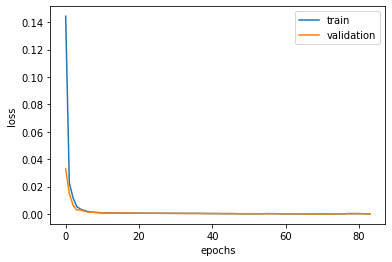

In [12]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

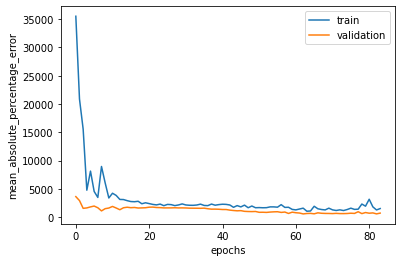

In [13]:
plt.plot(history.history['mean_absolute_percentage_error'], label='train')
plt.plot(history.history['val_mean_absolute_percentage_error'], label='validation')
plt.xlabel('epochs')
plt.ylabel('mean_absolute_percentage_error')
plt.legend()
plt.show()

In [20]:
sample = 2

y_pred = model_e2d2.predict(
    [x_train[sample].reshape(1, max_x_len, 5), np.arange(max_x_len).reshape(1, max_x_len)]
    ).reshape(max_x_len, 2)

y_pred.shape, x_train[sample].shape

((77, 2), (77, 5))

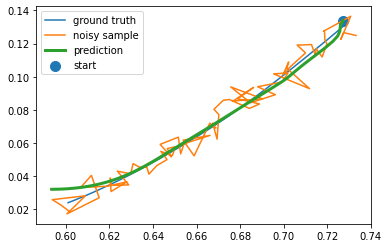

In [21]:
plt.plot(y_train[sample][:, 0], y_train[sample][:, 1], label='ground truth')
plt.plot(x_train[sample][:, 0], x_train[sample][:, 1], label='noisy sample')
plt.plot(y_pred[:, 0], y_pred[:, 1], label='prediction', linewidth=3)
plt.scatter(y_pred[:, 0][0], y_pred[:, 1][0], label='start', s=100)

plt.legend()
plt.show()